In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from time import time
import itertools, operator, gc, os
import multiprocessing as mp
import xgboost as xgb

/opt/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
label_name = 'mt_hh'
os.system('mkdir '+label_name)
paths = ['../../../data/pnc/inbound/clv_hhsamp'+n+'.csv' for n in list('1234')]

Check the size of the raw datasets.

In [3]:
!ls ../../../data/pnc/inbound/clv_hhsamp* -l

-rw-rw-r-- 1 pp77408 pnc 7337336109 Jul 21 13:23 ../../../data/pnc/inbound/clv_hhsamp1.csv
-rw-rw-r-- 1 pp77408 pnc 7389758266 Jul 21 13:24 ../../../data/pnc/inbound/clv_hhsamp2.csv
-rw-rw-r-- 1 pp77408 pnc 7377484066 Jul 21 13:24 ../../../data/pnc/inbound/clv_hhsamp3.csv
-rw-rw-r-- 1 pp77408 pnc 7417494070 Jul 21 13:24 ../../../data/pnc/inbound/clv_hhsamp4.csv


Count how many observations in each file.

In [5]:
for path in paths:
    with open(path) as fp:
        count = 0
        for _ in fp:
            count += 1
    print(count)

# !wc -l < ../../../data/pnc/inbound/clv_hhsamp1.csv   ### Another way to count lines using bash command

5914362
5956953
5945807
5978154


# -------------------- Question 1 (product ownership) --------------------

## Extracting and saving eligible data

In [5]:
def sel_sample(path, feature, values, chunksize, usecols=None):
    '''
    Input: 
        path (str): the file path of target csv file.
        feature (str): the variable name for selecting samples.
        values (list): the desired values of the 'feature'.
        chunksize (int): same as chunksize in 'pd.read_csv'.
        usecols (list): the desired column names.
    Output:
        dataset only containing columns in 'usecols' and samples satisfying "'feature' in 'values'".
    '''
    reader = pd.read_csv(path, chunksize=chunksize, usecols=usecols)
    items = []
    start = time()
    for j, chunk in enumerate(reader):
        items.append(chunk.loc[chunk[feature].isin(values)])
        if j%10 == 9:
            print('{} seconds: completed {} rows'.format(round(time() - start,2), (j+1)*chunksize))
    data = pd.concat(items)
    del items
    gc.collect()
    return data

def get_data_q1(paths, label_name, sel_by, sv_label, sv_feature):
    '''
    Input:
        paths (list): the list of file paths.
        label_name (str): the column name of label (y).
        sel_by (str): the name of sample-selecting feature (Here, we use 'time_period').
        sv_label (str): the value of 'sel_by' for selecting label data.
        sv_feature (list): the list of values of 'sel_by' for selecting feature data.
    Output:
        The final eligible dataset containing labels (y).
    '''
    start = time()
    
    parallel = mp.Pool(processes=len(paths))
    returner = [parallel.apply_async(sel_sample, args=(paths[i],), 
                kwds={'feature':sel_by, 'values':sv_feature+[sv_label], 'chunksize':100000, 'usecols':None})
                for i in range(len(paths))]
    print('Begin extracting data ...')
    items = pd.concat([data.get() for data in returner])
    parallel.close()
    parallel.join()
    
    print('Done! Begin processing the data ...')
    data_X = items.loc[items[sel_by]==sv_feature[0]]
    for j in range(len(sv_feature)-1):
        data_X_imp = items.loc[items[sel_by]==sv_feature[j+1]]
        data_X_imp = data_X_imp.loc[data_X_imp.rlb_location_key.isin(set(data_X_imp.rlb_location_key) - set(data_X.rlb_location_key))]
        data_X = pd.concat([data_X, data_X_imp])
    data_y = items.loc[items[sel_by]==sv_label,[label_name,'rlb_location_key']]
    data_Xy = pd.merge(data_X, data_y[['rlb_location_key',label_name]], suffixes=['_x',''],
                       how='inner', on='rlb_location_key').drop([label_name+'_x',], axis=1)
    print('Done!')
    print('The overall processing time is {} seconds.'.format(round(time() - start,2)))
    del data_X, data_X_imp, data_y
    gc.collect()
    return data_Xy.sort_values('rlb_location_key').reset_index(drop=True)    

In [6]:
data = get_data_q1(paths, label_name, 'time_period', '2017-06-30', ['2017-04-30', '2017-05-31'])
### The above line only needs one time implementation, then we can reload the saved data instead.
gc.collect()
data.to_csv(label_name+'/data_q1_2017.csv', index=False)

Begin extracting data ...
41.36 seconds: completed 1000000 rows
42.35 seconds: completed 1000000 rows
42.62 seconds: completed 1000000 rows
43.07 seconds: completed 1000000 rows
79.05 seconds: completed 2000000 rows
80.6 seconds: completed 2000000 rows
80.91 seconds: completed 2000000 rows
81.73 seconds: completed 2000000 rows
116.47 seconds: completed 3000000 rows
119.17 seconds: completed 3000000 rows
120.0 seconds: completed 3000000 rows
120.55 seconds: completed 3000000 rows
155.94 seconds: completed 4000000 rows
158.2 seconds: completed 4000000 rows
158.41 seconds: completed 4000000 rows
160.24 seconds: completed 4000000 rows


/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


195.83 seconds: completed 5000000 rows
195.87 seconds: completed 5000000 rows
196.2 seconds: completed 5000000 rows


/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


198.53 seconds: completed 5000000 rows


/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()
/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


231.64 seconds: completed 6000000 rows
233.17 seconds: completed 6000000 rows
233.45 seconds: completed 6000000 rows
235.75 seconds: completed 6000000 rows
Done! Begin processing the data ...
Done!
The overall processing time is 259.01 seconds.


Reload the data if it has been saved before.

In [3]:
data = pd.read_csv(label_name+'/data_q1_2017.csv')

Check data size and the positive rate of response.

In [4]:
print('Data size:', data.shape)
print('# of positive labels:', sum(data[label_name]))
print('Positive rate:', round(sum(data[label_name])/data.shape[0],4))

Data size: (371019, 292)
# of positive labels: 26612
Positive rate: 0.0717


## Data pre-processing

Drop some 'bad' features. (Bruce provided the list.)

In [187]:
### read the dropped list from a csv file.
col_drop = list(pd.read_csv('drop_list.csv', header=None)[0])

In [5]:
col_drop = ['rlb_location_key',
            'time_period',
            'rel_tenure_src',
            'dd_agr_type',
            'sv_agr_type',
            'mm_agr_type',
            'cd_agr_type',
            'cd_ira_agr_type',
            'bk_agr_type',
            'bk_ira_agr_type',
            'ir_agr_type',
            'pp_agr_type',
            'cc_agr_type',
            'mt_agr_type',
            'heil_agr_type',
            'heloc_agr_type',
            'pil_agr_type',
            'ploc_agr_type',
            'auto_agr_type',
            'sl_agr_type',
            'iil_agr_type',
            'sd_agr_type',
            'in_agr_type',
            'psycle_code_ne',
            'sls_branch_book',
            'market_book',
            'zip_code',
            'market_zip',
            'rcb_consumer_hh',
            'total_profit',
            'total_profit_var',
            'total_rev',
            'total_net_int_inc',
            'total_non_int_inc',
            'total_exp',
            'total_exp_fix',
            'total_exp_var',
            'total_exp_dis',
            'mt_acct',
            'mt_bal',
            'mt_int',
            'mt_rev',
            'mt_exp',
            'mt_tenure',
            'mt_conv_hh',
            'mt_start_bal',
            'ixiwc_total_assets',
            'ixiwc_inv',
            'ixiwc_deposits',
            'ixiwc_dd',
            'ixiwc_sv',
            'ixiwc_mm',
            'ixiwc_cd',
            'fico_auto',
            'fico_cc',
            'fico_heil',
            'fico_heloc',
            'fico_mt',
            'date_opened_first_prod']

data = data.drop(col_drop, axis=1)

In [6]:
X = data.drop(label_name, axis=1)
y = data[label_name]

Reduce the cardinality of the feature 'dma'.
*(If the level count is greater than 5000, then keep it; otherwise throw it into a 'Garbage' group.)*

In [7]:
dma_entry = list(X.dma.value_counts().index[X.dma.value_counts()<=5000])
X.loc[X.dma.isin(dma_entry),'dma'] = 'Garbage'
X.dma.value_counts()

Garbage                    101837
Philadelphia, PA            36558
Pittsburgh, PA              28241
New York, NY                27540
Washington et al, DC-MD     21834
Chicago, IL                 21642
Cleveland et al, OH         18696
Detroit, MI                 14610
Baltimore, MD               11595
Indianapolis, IN            11115
Cincinnati, OH              10860
Louisville, KY              10070
Columbus, OH                 9897
Harrisburg et al, PA         7307
W. Palm Beach et al, FL      7050
Atlanta, GA                  6913
Wilkes Barre et al, PA       6877
Raleigh et al, NC            6504
Grand Rapids et al, MI       5782
Orlando et al, FL            5007
Name: dma, dtype: int64

List all the categorical variables (to be dummified).

In [8]:
col_cat = ['inc_code_hh',
           'hh_agr_type',
           'core_agr_type',
           'new_hh_traj_acq',
           'new_hh_traj_seg',
           'sales_channel',
           'age_grp_4L',
           'age_hh_src',
           'inc_grp_3L',
           'inc_code_hh_src',
           'consumer_segment',
           'lifestage',
           'dma',
           'market_clv']

col_rename = ['new_hh_traj_acq',
              'new_hh_traj_seg',
              'sales_channel',
              'age_grp_4L',
              'inc_grp_3L',
              'consumer_segment',
              'dma',
              'market_clv']

Replace 'NaN's in all categorical features with 'missing'. (Categorical variables containing NaNs may not be dummified.)

In [9]:
for f in col_cat:
    if sum(X[f].isnull()) > 0:
        X.loc[X[f].isnull(),f] = 'missing'

Dummify categorical variables and rename some new resulting dummy variables.
(B/c xbgoost requires variable names not containing spaces, '[' , ']' and '<'.)

In [10]:
dict_rename = dict()
for i, f in enumerate(col_rename):
    keys = [f+'_'+item for item in X[f].value_counts().index]
    values = [f+'_'+''.join(filter(lambda ch: ch not in " []<", item)) for item in X[f].value_counts().index]
    dict_rename = {**dict_rename, **dict(zip(keys, values))}

In [11]:
X = pd.get_dummies(X, columns=col_cat, drop_first=True)
X.rename(columns=dict_rename, inplace=True)

## Running XGBoost

In [12]:
gc.collect()
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=66666)

In [18]:
n_iter = None # 1300 # 

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.05
param['eval_metric'] = 'auc'
param['max_depth'] = 6
param['min_child_weight'] = 3
param['subsample'] = 0.8
param['colsample_bytree'] = 0.8
param['gamma'] = 0
param['base_score'] = np.mean(y_trn)
param['silent'] = True
param['scale_pos_weight'] = 1
# param['seed'] = 100

trn = xgb.DMatrix(X_trn, label=y_trn)
if n_iter == None:
    print('Begin tunning parameters ...')
    res = xgb.cv(param, trn, nfold=4, 
                 stratified=True, num_boost_round=5000, early_stopping_rounds=50,
                 verbose_eval=50, show_stdv=True, metrics={'auc'}, maximize=True)
    min_index = np.argmax(res['test-auc-mean'])
    print('Done! The best iteration number is', min_index)
else:
    min_index = n_iter
    print('The pre-selected iteration number is', min_index)
print('Begin fitting model ...')
tst = xgb.DMatrix(X_tst, label=y_tst)
model = xgb.train(param, trn, min_index, [(trn,'train'), (tst, 'test')], verbose_eval=50)

pred = model.predict(tst)
print('Done! Test AUC:', roc_auc_score(y_tst, pred))

Begin tunning parameters ...
[0]	train-auc:0.94412+0.00067755	test-auc:0.943029+0.00202235
[50]	train-auc:0.977818+0.000547906	test-auc:0.975605+0.00110704
[100]	train-auc:0.990455+0.00019138	test-auc:0.988228+0.000909715
[150]	train-auc:0.995539+0.000161328	test-auc:0.993828+0.000736117
[200]	train-auc:0.99682+0.000181921	test-auc:0.995431+0.000627079
[250]	train-auc:0.997206+0.000167038	test-auc:0.995969+0.000576852
[300]	train-auc:0.997405+0.000150461	test-auc:0.996271+0.000533559
[350]	train-auc:0.997554+0.000147881	test-auc:0.996459+0.000493918
[400]	train-auc:0.997699+0.000118143	test-auc:0.99659+0.000482126
[450]	train-auc:0.997843+0.000117014	test-auc:0.996694+0.000485471
[500]	train-auc:0.99797+9.70322e-05	test-auc:0.996776+0.000482092
[550]	train-auc:0.998093+9.255e-05	test-auc:0.996845+0.000480759
[600]	train-auc:0.998212+9.38123e-05	test-auc:0.9969+0.000472831
[650]	train-auc:0.998329+9.01194e-05	test-auc:0.996953+0.000467188
[700]	train-auc:0.998449+8.72765e-05	test-auc:0.

Save/reload the model.

In [4]:
import pickle
# pickle.dump(model, open(label_name+"/xgbmodel_q1.pickle.dat", "wb"))
model = pickle.load(open(label_name+"/xgbmodel_q1.pickle.dat", "rb"))

Feature importance:


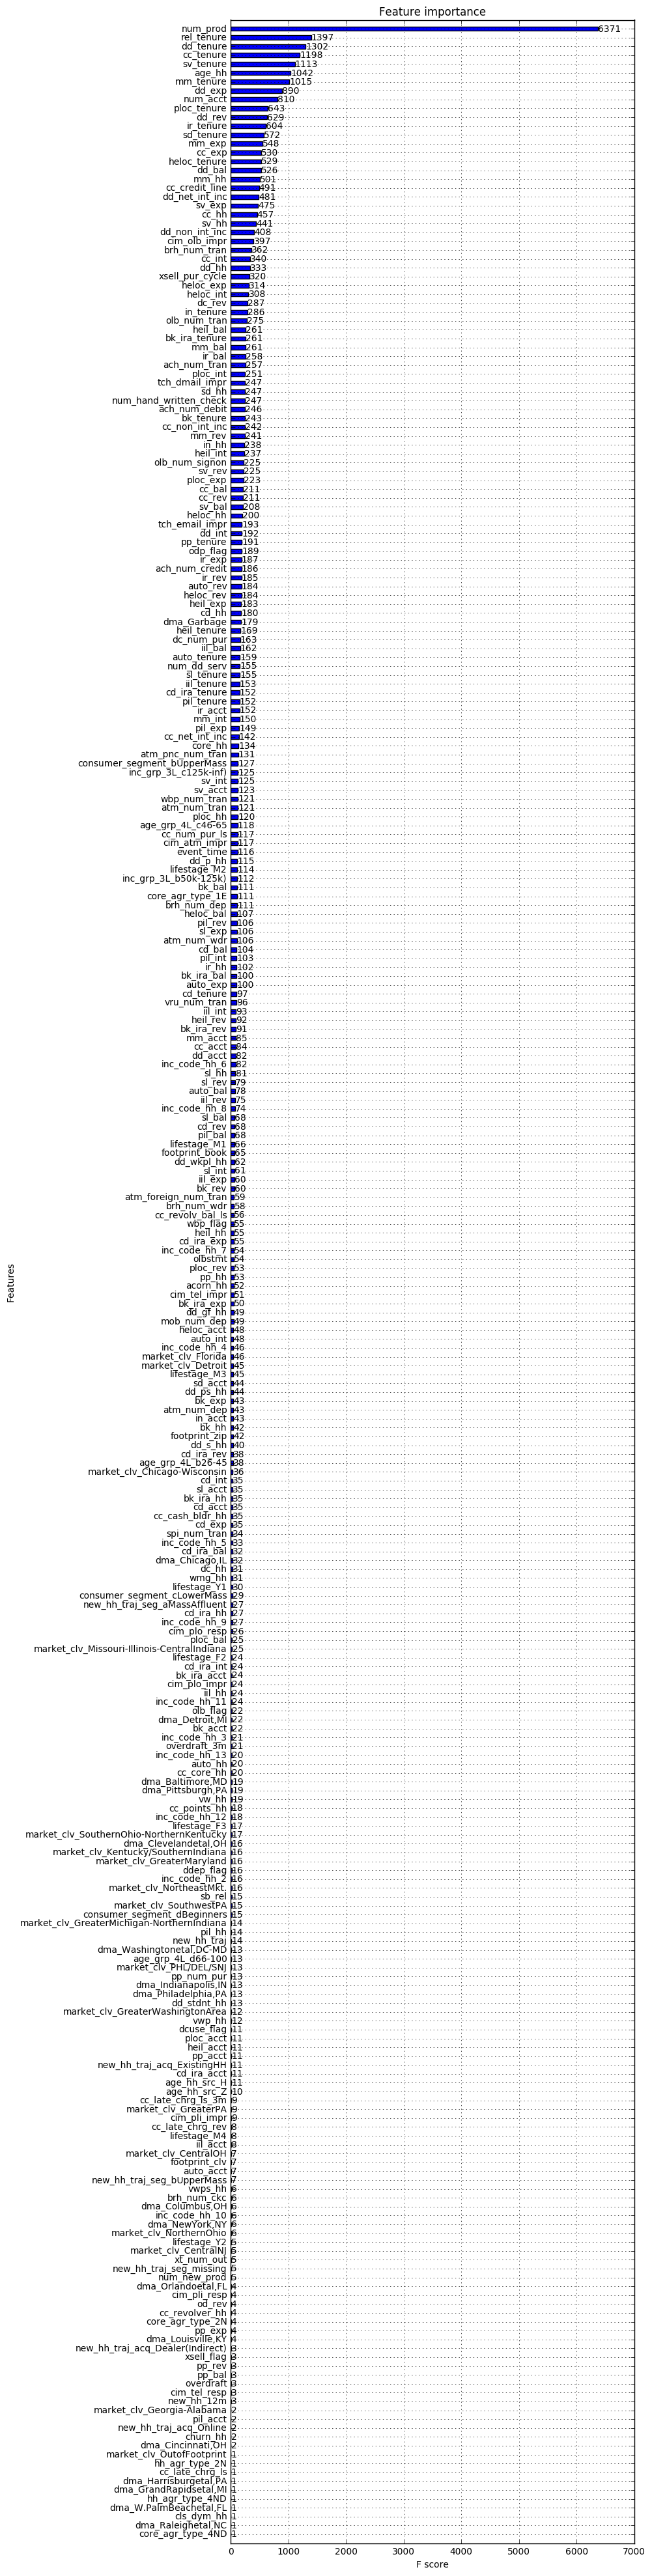

In [14]:
print('Feature importance:')
fig, ax = plt.subplots(1,1,figsize=(8,50))
xgb.plot_importance(model, height=0.5, ax=ax)

In [10]:
def print_top_features(xgb_model, nb_features=30, saveto=False):
    print('Top 30 features and scores:')
    print('--------------------------')
    fea_imp = sorted(xgb_model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)
    if nb_features == 'all':
        nb_features=len(fea_imp)
    top_fea = pd.DataFrame({'feature':list(zip(*fea_imp[:nb_features]))[0], 'score':list(zip(*fea_imp[:nb_features]))[1]})
    if saveto:
        top_fea.to_csv(saveto, index=False)
    print(top_fea)
    
print_top_features(model, nb_features='all', saveto=label_name+'/fea_imp.csv')

Top 30 features and scores:
--------------------------
                              feature  score
0                            num_prod   6371
1                          rel_tenure   1397
2                           dd_tenure   1302
3                           cc_tenure   1198
4                           sv_tenure   1113
5                              age_hh   1042
6                           mm_tenure   1015
7                              dd_exp    890
8                            num_acct    810
9                         ploc_tenure    643
10                             dd_rev    629
11                          ir_tenure    604
12                          sd_tenure    572
13                             mm_exp    548
14                             cc_exp    530
15                       heloc_tenure    529
16                             dd_bal    526
17                              mm_hh    501
18                     cc_credit_line    491
19                     dd_net_int_inc    481


## Plot partial dependence

In [196]:
def xgb_partial_dependence(xgb_model, X_trn, feature, grid=100, plot=True, output=False, xrange=None, saveto=False):
    """
    This function plots the partial dependence of a specific feature.
    If 'grid' is less than the number of feature levels, then use its real levels as the grid.
    """
    avg_prob = []
    lb = min(X_trn[feature])
    ub = max(X_trn[feature])
    if len(np.unique(X_trn[feature])) < grid:
        points = list(np.unique(X_trn[feature]))
    else:
        step = (ub-lb)/(grid-1)
        points = np.arange(lb, ub+step, step)
    if xrange != None:
        step = (xrange[1]-xrange[0])/(grid-1)
        points = np.arange(xrange[0], xrange[1]+step, step)
    X_trn_p = X_trn.copy()    
    for p in points:
        X_trn_p.loc[:,feature] = p
        pred = xgb_model.predict(xgb.DMatrix(X_trn_p))
        avg_prob.append(np.mean(pred))
        gc.collect()
    if plot:
        f = plt.figure()
        plt.plot(points, avg_prob,'b')  
        plt.xlabel(feature)
        plt.ylabel('avg_prob')
        plt.show()
    if saveto:
        f.savefig(saveto)
    if output:
        return list(points), avg_prob

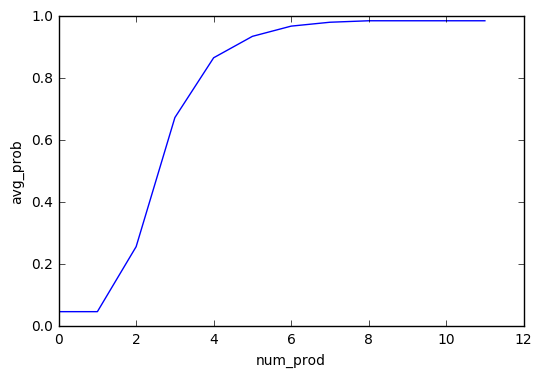

In [17]:
xgb_partial_dependence(model, X_trn, 'num_prod', grid=100, saveto=label_name+'/plot_num_prod.pdf')
# This function is time-consuming, should find some method to improve.

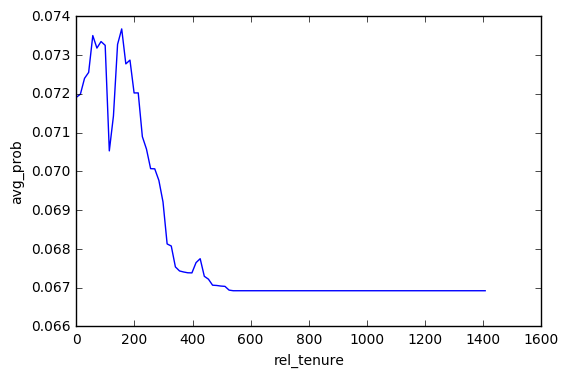

In [18]:
xgb_partial_dependence(model, X_trn, 'rel_tenure', grid=100)

In [ ]:
xgb_partial_dependence(model, X_trn, 'dd_tenure', grid=100)

# -------------------- Question 2 (product opening) --------------------

## Extracting and saving eligible data

In [6]:
def sel_sample(path, feature, values, chunksize, usecols=None):
    '''
    Input: 
        path (str): the file path of target csv file.
        feature (str): the variable name for selecting samples.
        values (list): the desired values of the 'feature'.
        chunksize (int): same as chunksize in 'pd.read_csv'.
        usecols (list): the desired column names.
    Output:
        dataset only containing columns in 'usecols' and samples satisfying "'feature' in 'values'".
    '''
    reader = pd.read_csv(path, chunksize=chunksize, usecols=usecols)
    items = []
    start = time()
    for j, chunk in enumerate(reader):
        items.append(chunk.loc[chunk[feature].isin(values)])
        if j%10 == 9:
            print('{} seconds: completed {} rows'.format(round(time() - start,2), (j+1)*chunksize))
    data = pd.concat(items)
    del items
    gc.collect()
    return data

    
def get_data_q2(paths, label_name, sel_by, sv_label, sv_feature, sv_key, parallel=True):
    '''
    Input:
        paths (list): the list of file paths.
        label_name (str): the column name of label (y).
        sel_by (str): the name of sample-selecting feature (Here, we use 'time_period').
        sv_label (list): the list of values of 'sel_by' for selecting label data. (Here, we use 6 months)
        sv_feature (list): the list of values of 'sel_by' for selecting feature data.
        sv_key (str): the value of 'sel_by' for selecting eligible keys.
        parallel (bool): parallelization is much faster, recommend to use.
    Output:
        The final eligible dataset containing labels (y).
    '''
    start = time()
    if parallel:
        parallel = mp.Pool(processes=2*len(paths)) 
        returner = [parallel.apply_async(sel_sample, args=(paths[i],), 
                    kwds={'feature':sel_by, 'values':sv_feature+[sv_key], 'chunksize':100000, 'usecols':None})
                    for i in range(len(paths))]
        returner += [parallel.apply_async(sel_sample, args=(paths[i],), 
                    kwds={'feature':sel_by, 'values':sv_label, 'chunksize':100000, 'usecols':['rlb_location_key', label_name, sel_by]})
                    for i in range(len(paths))]

        print('Begin extracting data ...')
        items = pd.concat([p.get() for p in returner[:len(paths)]])
        data_y = pd.concat([p.get() for p in returner[len(paths):]])
        parallel.close()
        parallel.join()
        del parallel
        gc.collect()
        
        print('Done! Begin processing the data ...')
        keys = items.loc[(items[label_name]==0) & (items[sel_by]==sv_key), ['rlb_location_key']]
        data_y = data_y.groupby('rlb_location_key')[label_name].max().reset_index()
        # data_y = items.loc[items[sel_by].isin(sv_label),[label_name,'rlb_location_key']]
        data_X = items.loc[items[sel_by]==sv_feature[0]]        
        for j in range(len(sv_feature)-1):
            data_X_imp = items.loc[items[sel_by]==sv_feature[j+1]]
            data_X_imp = data_X_imp.loc[data_X_imp.rlb_location_key.isin(set(data_X_imp.rlb_location_key) - set(data_X.rlb_location_key))]
            data_X = pd.concat([data_X, data_X_imp]) 
        del items
        data_X = pd.merge(data_X, keys, on='rlb_location_key', how='inner')
        data_Xy = pd.merge(data_X.drop(label_name, axis=1), data_y, on='rlb_location_key', how='left')
        data_Xy.loc[:,label_name] = data_Xy[label_name].fillna(0)
        del data_X, data_y
        print('Done!')
        print('----------')
        print('The overall processing time is {} seconds.'.format(round(time() - start,2)))
        return data_Xy.sort_values('rlb_location_key').reset_index(drop=True)    
      
    else:
        for i, path in enumerate(paths):
            filename = path[-1*path[::-1].find('/'):] if path.find('/') != -1 else path
            print('====================')
            print('Begin extracting data from '+filename+' ......')
            items = sel_sample(path, sel_by, values=sv_feature+sv_label+[sv_key], chunksize=100000, usecols=None)

            print('Done! Begin processing the data ...' )
            keys = items.loc[(items[label_name]==0) & (items[sel_by]==sv_key), ['rlb_location_key']]
            data_X = items.loc[items[sel_by]==sv_feature[0]]        
            for j in range(len(sv_feature)-1):
                data_X_imp = items.loc[items[sel_by]==sv_feature[j+1]]
                data_X_imp = data_X_imp.loc[data_X_imp.rlb_location_key.isin(set(data_X_imp.rlb_location_key) - set(data_X.rlb_location_key))]
                data_X = pd.concat([data_X, data_X_imp])
            data_X = pd.merge(data_X, keys, on='rlb_location_key', how='inner')
            data_y = items.loc[items[sel_by].isin(sv_label),[label_name,'rlb_location_key']]
            data_y = data_y.groupby('rlb_location_key')[label_name].max().reset_index()
            data_Xy = pd.merge(data_X.drop(label_name, axis=1), data_y, on='rlb_location_key', how='left')

            data = pd.concat([data, data_Xy])
            print('Done!')
            del data_Xy, items
            gc.collect()
        data.loc[:,label_name] = data[label_name].fillna(0)
        print('----------')
        print('The overall processing time is {} seconds.'.format(round(time() - start,2)))
        return data.sort_values('rlb_location_key').reset_index(drop=True)

In [7]:
data = get_data_q2(paths, label_name, 'time_period', sv_label=['2016-11-30','2016-12-31','2017-01-31','2017-02-28','2017-03-31','2017-04-30'],
                   sv_feature=['2016-08-31','2016-09-30'], sv_key='2016-10-31')

Begin extracting data ...
10.38 seconds: completed 1000000 rows
10.41 seconds: completed 1000000 rows
11.54 seconds: completed 1000000 rows
12.1 seconds: completed 1000000 rows
20.53 seconds: completed 2000000 rows
20.87 seconds: completed 2000000 rows
27.09 seconds: completed 2000000 rows
28.29 seconds: completed 2000000 rows
32.24 seconds: completed 3000000 rows
36.72 seconds: completed 3000000 rows
39.23 seconds: completed 1000000 rows
39.75 seconds: completed 1000000 rows
39.78 seconds: completed 1000000 rows
41.3 seconds: completed 1000000 rows
45.44 seconds: completed 3000000 rows
48.54 seconds: completed 3000000 rows
54.91 seconds: completed 4000000 rows
57.69 seconds: completed 4000000 rows
68.02 seconds: completed 4000000 rows
73.01 seconds: completed 4000000 rows
80.26 seconds: completed 2000000 rows
80.53 seconds: completed 2000000 rows
83.44 seconds: completed 5000000 rows
85.86 seconds: completed 5000000 rows
87.12 seconds: completed 2000000 rows
87.39 seconds: completed 2

/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()
/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


215.67 seconds: completed 5000000 rows


/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


220.18 seconds: completed 5000000 rows
222.13 seconds: completed 5000000 rows


/opt/anaconda3/lib/python3.5/multiprocessing/process.py:249: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.run()


245.88 seconds: completed 6000000 rows
254.68 seconds: completed 6000000 rows
256.8 seconds: completed 6000000 rows
260.58 seconds: completed 6000000 rows
Done! Begin processing the data ...
Done!
----------
The overall processing time is 285.78 seconds.


In [ ]:
data.to_csv(label_name+'/data_q2_2016.csv', index=False)

In [13]:
data = pd.read_csv(label_name+'/data_q2_2016.csv')

Check data size and the positive rate of response.

In [14]:
print('Data size:', data.shape)
print('# of positive labels:', sum(data[label_name]))
print('Positive rate:', round(sum(data[label_name])/data.shape[0],4))

Data size: (348935, 292)
# of positive labels: 369.0
Positive rate: 0.0011


## Data pre-processing (same as Q1)

In [15]:
col_drop = ['rlb_location_key',
            'time_period',
            'rel_tenure_src',
            'dd_agr_type',
            'sv_agr_type',
            'mm_agr_type',
            'cd_agr_type',
            'cd_ira_agr_type',
            'bk_agr_type',
            'bk_ira_agr_type',
            'ir_agr_type',
            'pp_agr_type',
            'cc_agr_type',
            'mt_agr_type',
            'heil_agr_type',
            'heloc_agr_type',
            'pil_agr_type',
            'ploc_agr_type',
            'auto_agr_type',
            'sl_agr_type',
            'iil_agr_type',
            'sd_agr_type',
            'in_agr_type',
            'psycle_code_ne',
            'sls_branch_book',
            'market_book',
            'zip_code',
            'market_zip',
            'rcb_consumer_hh',
            'total_profit',
            'total_profit_var',
            'total_rev',
            'total_net_int_inc',
            'total_non_int_inc',
            'total_exp',
            'total_exp_fix',
            'total_exp_var',
            'total_exp_dis',
            'mt_acct',
            'mt_bal',
            'mt_int',
            'mt_rev',
            'mt_exp',
            'mt_tenure',
            'mt_conv_hh',
            'mt_start_bal',
            'ixiwc_total_assets',
            'ixiwc_inv',
            'ixiwc_deposits',
            'ixiwc_dd',
            'ixiwc_sv',
            'ixiwc_mm',
            'ixiwc_cd',
            'fico_auto',
            'fico_cc',
            'fico_heil',
            'fico_heloc',
            'fico_mt',
            'date_opened_first_prod']

data = data.drop(col_drop, axis=1)  ### col_drop is defined at the very beginning

X = data.drop(label_name, axis=1)
y = data[label_name]

dma_entry = list(X.dma.value_counts().index[X.dma.value_counts()<=5000])
X.loc[X.dma.isin(dma_entry),'dma'] = 'Garbage'

col_cat = ['inc_code_hh',
           'hh_agr_type',
           'core_agr_type',
           'new_hh_traj_acq',
           'new_hh_traj_seg',
           'sales_channel',
           'age_grp_4L',
           'age_hh_src',
           'inc_grp_3L',
           'inc_code_hh_src',
           'consumer_segment',
           'lifestage',
           'dma',
           'market_clv']

col_rename = ['new_hh_traj_acq',
              'new_hh_traj_seg',
              'sales_channel',
              'age_grp_4L',
              'inc_grp_3L',
              'consumer_segment',
              'dma',
              'market_clv']

for f in col_cat:
    if sum(X[f].isnull()) > 0:
        X.loc[X[f].isnull(),f] = 'missing'
        
dict_rename = dict()
for i, f in enumerate(col_rename):
    keys = [f+'_'+item for item in X[f].value_counts().index]
    values = [f+'_'+''.join(filter(lambda ch: ch not in " []<", item)) for item in X[f].value_counts().index]
    dict_rename = {**dict_rename, **dict(zip(keys, values))}
    
X = pd.get_dummies(X, columns=col_cat, drop_first=True)
X.rename(columns=dict_rename, inplace=True)

gc.collect()

224

## Running XGBoost

In [16]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=66666)

In [17]:
n_iter = None # 300 # 

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.01
param['eval_metric'] = 'auc'
param['max_depth'] = 6
param['min_child_weight'] = 3
param['subsample'] = 0.8
param['colsample_bytree'] = 0.8
param['gamma'] = 0
param['base_score'] = np.mean(y_trn)
param['silent'] = True
param['scale_pos_weight'] = 1 # (len(y)-sum(y_trn))/sum(y_trn) # 
# param['seed'] = 100

trn = xgb.DMatrix(X_trn, label=y_trn)
if n_iter == None:
    print('Begin tunning parameters ...')
    res = xgb.cv(param, trn, nfold=4, 
                 stratified=True, num_boost_round=5000, early_stopping_rounds=50,
                 verbose_eval=50, show_stdv=True, metrics={'auc'}, maximize=True)
    min_index = np.argmax(res['test-auc-mean'])
    print('Done! The best iteration number is', min_index)
else:
    min_index = n_iter
    print('The pre-selected iteration number is', min_index)
print('Begin fitting model ...')
tst = xgb.DMatrix(X_tst, label=y_tst)
model = xgb.train(param, trn, min_index, [(trn,'train'), (tst, 'test')], verbose_eval=50)

pred = model.predict(tst)
print('Done!')
print('Test ROC AUC:', roc_auc_score(y_tst, pred))

Begin tunning parameters ...
[0]	train-auc:0.788363+0.00666618	test-auc:0.666834+0.0448487
[50]	train-auc:0.88546+0.00102896	test-auc:0.767726+0.0100475
[100]	train-auc:0.901329+0.00419995	test-auc:0.774299+0.00885199
[150]	train-auc:0.912319+0.00453646	test-auc:0.777622+0.00864089
[200]	train-auc:0.919972+0.00581594	test-auc:0.780764+0.00793219
[250]	train-auc:0.926572+0.00646565	test-auc:0.781166+0.00806018
[300]	train-auc:0.932436+0.00682366	test-auc:0.781747+0.00900965
[350]	train-auc:0.93765+0.00720121	test-auc:0.781705+0.00920559
Done! The best iteration number is 316
Begin fitting model ...
[0]	train-auc:0.802323	test-auc:0.657571
[50]	train-auc:0.881693	test-auc:0.733035
[100]	train-auc:0.891306	test-auc:0.744984
[150]	train-auc:0.901544	test-auc:0.745509
[200]	train-auc:0.909886	test-auc:0.749205
[250]	train-auc:0.916866	test-auc:0.751335
[300]	train-auc:0.922976	test-auc:0.75435
Done!
Test ROC AUC: 0.754358972902
Test PR AUC: 0.00289514041887


Save/reload the model.

In [18]:
import pickle
pickle.dump(model, open(label_name+"/xgbmodel_q2.pickle.dat", "wb"))
model = pickle.load(open(label_name+"/xgbmodel_q2.pickle.dat", "rb"))

Feature importance:


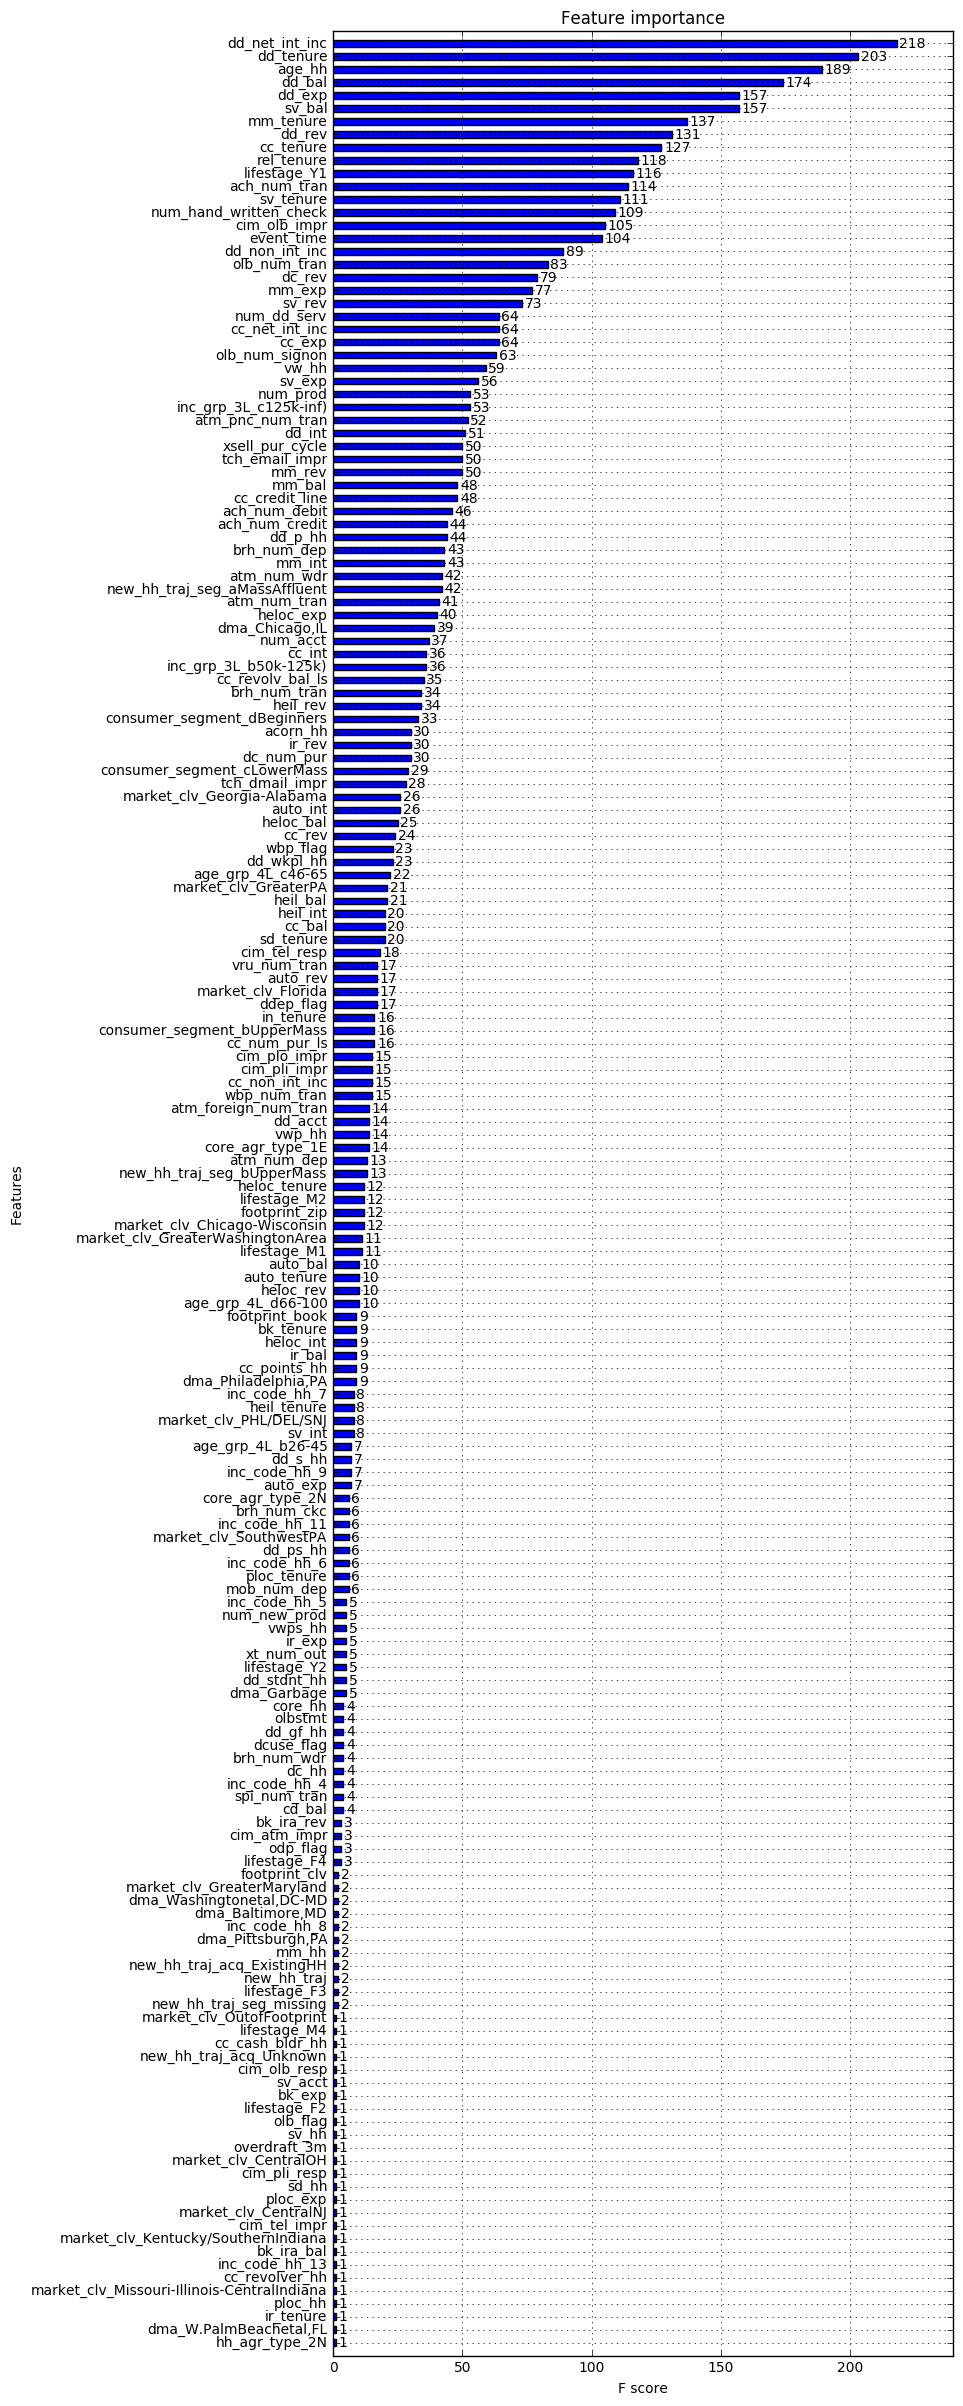

In [19]:
print('Feature importance:')
fig, ax = plt.subplots(1,1,figsize=(8,30))
xgb.plot_importance(model, height=0.5, ax=ax)

In [20]:
def print_top_features(xgb_model, nb_features=30):
    print('Top 30 features and scores:')
    print('--------------------------')
    fea_imp = sorted(xgb_model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)
    print(pd.DataFrame({'feature':list(zip(*fea_imp[:nb_features]))[0], 'score':list(zip(*fea_imp[:nb_features]))[1]}))
    
print_top_features(model, nb_features=30)

Top 30 features and scores:
--------------------------
                   feature  score
0           dd_net_int_inc    218
1                dd_tenure    203
2                   age_hh    189
3                   dd_bal    174
4                   sv_bal    157
5                   dd_exp    157
6                mm_tenure    137
7                   dd_rev    131
8                cc_tenure    127
9               rel_tenure    118
10            lifestage_Y1    116
11            ach_num_tran    114
12               sv_tenure    111
13  num_hand_written_check    109
14            cim_olb_impr    105
15              event_time    104
16          dd_non_int_inc     89
17            olb_num_tran     83
18                  dc_rev     79
19                  mm_exp     77
20                  sv_rev     73
21                  cc_exp     64
22          cc_net_int_inc     64
23             num_dd_serv     64
24          olb_num_signon     63
25                   vw_hh     59
26                  sv_exp 

In [24]:
def xgb_partial_dependence(xgb_model, X_trn, feature, grid=100, plot=True, output=False, xrange=None):
    """
    This function plots the partial dependence of a specific feature.
    If 'grid' is less than the number of feature levels, then use its real levels as the grid.
    """
    avg_prob = []
    lb = min(X_trn[feature])
    ub = max(X_trn[feature])
    if len(np.unique(X_trn[feature])) < grid:
        points = list(np.unique(X_trn[feature]))
    else:
        step = (ub-lb)/(grid-1)
        points = np.arange(lb, ub+step, step)
    if xrange != None:
        step = (xrange[1]-xrange[0])/(grid-1)
        points = np.arange(xrange[0], xrange[1]+step, step)
    X_trn_p = X_trn.copy()    
    for p in points:
        X_trn_p.loc[:,feature] = p
        pred = xgb_model.predict(xgb.DMatrix(X_trn_p))
        avg_prob.append(np.mean(pred))
        gc.collect()
    if plot:
        plt.plot(points, avg_prob,'b')  
        plt.xlabel(feature)
        plt.ylabel('avg_prob')
        plt.show()
    if output:
        return list(points), avg_prob

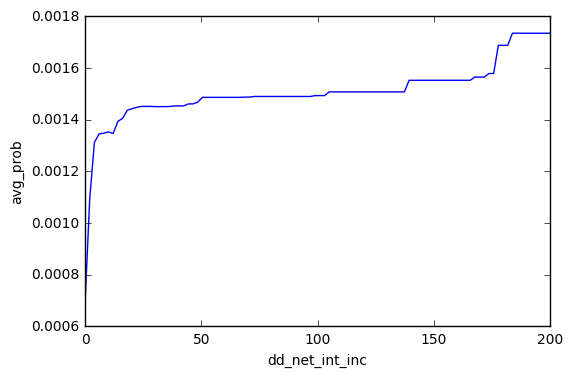

In [25]:
xgb_partial_dependence(model, X_trn, 'dd_net_int_inc', grid=100, xrange=(0,200))
# This function is time-consuming, should find some method to improve.

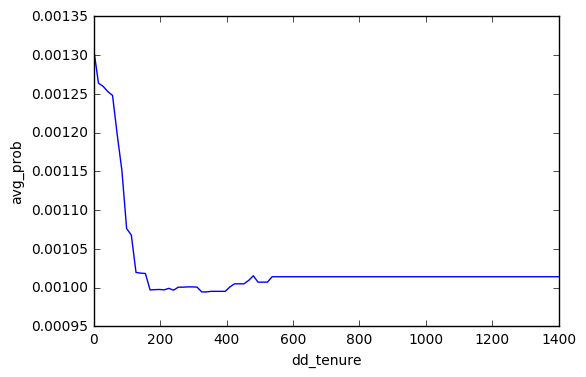

In [26]:
xgb_partial_dependence(model, X_trn, 'dd_tenure', grid=100)